In [1]:
# change the name of this variable to use a differnet dataset.
DATASET_NAME = 'gse129705'

In [2]:
# change these hyperparameters we search through.


# for lasso
group_reg_lesso = [0.2  * i for i in range(1, 6)]
l1_reg_lasso = [0.05  * i for i in range(6)]

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from group_lasso import LogisticGroupLasso


seed_value = 314159
np.random.seed(seed_value)

LogisticGroupLasso.LOG_LOSSES = True

In [4]:
import os
import math
import random
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import lmdb
import pickle
from torch_geometric.data import Batch
import torch
import time
import torch.nn as nn
from torch_geometric.nn import GATConv, GCNConv, TAGConv, knn
from torch.nn import Linear, Dropout, Softmax, LeakyReLU
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import global_mean_pool
from hashlib import sha1
from sklearn.tree import DecisionTreeClassifier, plot_tree
from natsort import natsorted, ns

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16
from sklearn.compose import ColumnTransformer, make_column_transformer


from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier


TRAIN_PROP = 0.8



In [5]:
# Load CSV From File
dataset_root = os.path.join(".", "data", DATASET_NAME)

raw_dataset = os.path.join(dataset_root, "raw")
processed_dataset = os.path.join(dataset_root, "processed")

patient_dataset = os.path.join(raw_dataset, "Patients.csv")


patient_data = pd.read_csv(patient_dataset, index_col=0)

patient_data

,RESPONSE,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
PATIENTS,,,,,,,,,,,,,,,,,,,,,
C1.43.MO3,1,3.21886,2.92638,0.0,-0.00170,-0.11964,0.0,0.0,1.21708,-0.01241,...,0.48440,0.67825,1.27458,2.56664,3.65988,0.0,2.08857,8.15220,4.08362,2.54912
C1.80.BL,0,2.79139,2.17104,0.0,-0.00170,0.00418,0.0,0.0,0.00721,-0.01241,...,1.77028,0.97612,-0.23791,0.17924,4.36598,0.0,2.48187,9.74258,5.85674,2.97492
C1.76.BL,0,2.11091,1.72769,0.0,-0.00170,-0.11964,0.0,0.0,0.00721,-0.01241,...,1.49443,0.98745,-0.23791,0.78520,5.42406,0.0,3.19363,9.97302,6.49395,3.10468
C1.119.BL,0,0.59019,2.54274,0.0,-0.00170,-0.11964,0.0,0.0,0.00721,-0.01241,...,2.19427,0.11299,-0.11873,1.71442,5.60907,0.0,3.42543,9.48793,6.73700,2.20381
C1.52.BL,0,1.73618,1.99748,0.0,-0.00170,-0.11964,0.0,0.0,0.00721,1.47855,...,1.66573,2.66391,0.91689,2.72109,5.97159,0.0,3.02657,9.51062,6.66191,3.56577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2.62.BL,0,2.32722,2.78940,0.0,0.00308,0.21916,0.0,0.0,-0.00846,0.02251,...,0.88491,1.26625,0.30662,1.58260,5.03738,0.0,2.84432,10.15322,5.90220,1.81392
C2.46.MO3,1,1.84743,2.86524,0.0,0.00308,0.21916,0.0,0.0,-0.00846,0.02251,...,1.54364,1.73128,0.49104,2.50169,5.32422,0.0,3.49868,10.21646,6.20677,2.96830
C2.63.MO3,1,1.30736,2.92271,0.0,0.00308,0.21916,0.0,0.0,-0.00846,0.02251,...,2.26259,1.89086,0.78755,2.93408,4.96799,0.0,3.49305,8.51598,5.97901,3.34918


In [6]:
NUM_EXAMPLES = len(patient_data.index)
NUM_TRAIN = int(TRAIN_PROP * NUM_EXAMPLES)
NUM_TEST = NUM_EXAMPLES - NUM_TRAIN
NUM_VAL = math.ceil(NUM_TRAIN * (1 - TRAIN_PROP))

NUM_VAL

21

In [7]:
r = random.Random(seed_value)

PERSON_ORDER = [90, 96, 110, 63, 105, 78, 111, 24, 70, 3, 59, 71, 124, 58, 22, 42, 10, 28, 1, 83, 95, 9, 33, 98, 119, 19, 123, 64, 15, 29, 80, 117, 16, 67, 55, 34, 5, 49, 48, 11, 102, 75, 74, 54, 7, 18, 116, 21, 114, 107, 38, 118, 88, 47, 27, 92, 60, 73, 26, 53, 40, 36, 46, 45, 109, 17, 91, 72, 120, 39, 84, 65, 14, 25, 4, 100, 126, 12, 31, 37, 103, 85, 2, 76, 101, 99, 43, 125, 32, 115, 30, 87, 44, 51, 61, 35, 122, 69, 52, 106, 6, 97, 86, 81, 113, 56, 62, 20, 94, 0, 50, 41, 121, 68, 108, 13, 79, 82, 66, 57, 89, 104, 93, 112, 23, 127, 77, 8]

"""
PERSON_ORDER = [i for i in range(NUM_EXAMPLES)]
r.shuffle(PERSON_ORDER)
"""

'\nPERSON_ORDER = [i for i in range(NUM_EXAMPLES)]\nr.shuffle(PERSON_ORDER)\n'

In [8]:
MASTER_GENE_SET = set([g for g in patient_data][1:])

In [9]:
# Process Graphs.


class Graph:
    def __init__(self, name, nodes, edges, genes, mask):
        self.name = name # a string to identify this graph
        self.nodes = nodes # A dict of node names to the genes in that node.
    
        self.edges = edges # a 2 x num_edges array, where the first row is source, and the second is dest.


        self.genes = genes # a sorted list of genes included in both this graph and the provided patient csv
    
        self.mask = mask # a num_nodes * num_genes boolean array. If mask[i][j] is True, that means gene j is included in node i.

    def edge_matrix(self):
        num_edges = len(self.edges[0])

        matrix = numpy.full((2, 2), False)

        for i in range(num_edges):
            src = self.edges[0][i]
            dst = self.edges[1][i]

            matrix[dst][src] = True

        return matrix


# returns a 2 x num_edges array.
def get_edges(graph_file):
    num_edges = int(graph_file.readline())


    cur_edges = []

    for _ in range(num_edges):
        line = graph_file.readline()

        parts = line.split(",")

        cur_edges.append((str(parts[0]).strip(), str(parts[1]).strip()))

    src, dst = zip(*cur_edges)

    src, dst = list(src), list(dst)

    cur_edges = [src, dst]

    return cur_edges


# cur_nodes is a dict, genes is a sorted list.
def get_nodes_and_genes(graph_file):
    num_nodes = int(graph_file.readline())

    cur_nodes = dict()

    genes = set()
    # process the genes, get the gene map, and the list of genes.
    for _ in range(num_nodes):
        line = graph_file.readline().strip()
        parts = line.split(",")

        cur_genes = parts[1:]

        cur_genes = [g for g in cur_genes if g in MASTER_GENE_SET]

        if ("" not in cur_genes):
            cur_nodes[parts[0]] = cur_genes
    
            genes.update(cur_genes)

    genes = list(genes)
    genes = natsorted(genes)



    return cur_nodes, genes


# a num_nodes x num_genes array. If mask[i][j] is true, that means node i contains gene j.
def get_mask(cur_nodes, genes):
    genes = list(genes)
    genes = natsorted(genes)

    node_list = [n for n in cur_nodes.keys()]
    node_list =  natsorted(node_list)


    mask = []

    for node in node_list:
        cur_genes = cur_nodes[node]

        mask.append([True if g in cur_genes else False for g in genes])


    mask = np.array(mask)

    return mask

In [10]:
graph_dataset = os.path.join(raw_dataset, "Graphs")

graph_files = os.listdir(graph_dataset)
graph_files = natsorted(graph_files)

graph_list = []


# will have as many 0's as there are nodes in the first graph, as many 1's as nodes in the second, etc.

# essentially, lasso_groups[i] tells you which graph the [i'th] col of the dataframe we're making belongs to.

for i, gl in enumerate(graph_files):
    graph_file = os.path.join(graph_dataset, gl)

    graph_file = open(graph_file)

    cur_edges = get_edges(graph_file)

    cur_nodes, genes = get_nodes_and_genes(graph_file)

    mask = get_mask(cur_nodes, genes)

    
    graph_list.append(Graph(gl, cur_nodes, cur_edges, genes, mask))


In [11]:
# making the giant dataframe for group_lasso

lasso_data = np.array(patient_data['RESPONSE'])

lasso_data = np.expand_dims(lasso_data, axis=1)

col_names = ["label"]
lasso_groups = []

for i, graph in enumerate(graph_list):
    genes = graph.genes
    name = graph.name
    lasso_groups.extend([i] * len(genes))

    col_names.extend([f"{name}_{gene}" for gene in genes])
    lasso_data = np.hstack((lasso_data, np.array(patient_data[graph.genes])))

In [12]:
df = pd.DataFrame(lasso_data, patient_data.index, col_names) 

df

,label,AGE-RAGE signaling pathway in diabetic complications.txt_AGER,AGE-RAGE signaling pathway in diabetic complications.txt_AGT,AGE-RAGE signaling pathway in diabetic complications.txt_AGTR1,AGE-RAGE signaling pathway in diabetic complications.txt_AKT3,AGE-RAGE signaling pathway in diabetic complications.txt_BAX,AGE-RAGE signaling pathway in diabetic complications.txt_BCL2,AGE-RAGE signaling pathway in diabetic complications.txt_CASP3,AGE-RAGE signaling pathway in diabetic complications.txt_CCL2,AGE-RAGE signaling pathway in diabetic complications.txt_CCND1,...,p53 signaling pathway.txt_STEAP3,p53 signaling pathway.txt_TEP1,p53 signaling pathway.txt_THBS1,p53 signaling pathway.txt_TNFRSF10B,p53 signaling pathway.txt_TP53,p53 signaling pathway.txt_TP53AIP1,p53 signaling pathway.txt_TP73,p53 signaling pathway.txt_TSC2,p53 signaling pathway.txt_ZMAT3,p53 signaling pathway.txt_ZNF385A
PATIENTS,,,,,,,,,,,,,,,,,,,,,
C1.43.MO3,1.0,5.99755,0.0,0.0,2.73219,6.74621,3.70124,5.07138,-0.00871,-0.00447,...,1.09594,5.31689,4.76415,6.19625,4.43874,0.0,0.0,5.05085,4.23904,7.52960
C1.80.BL,0.0,6.49587,0.0,0.0,3.03913,7.11058,4.91876,3.92118,-0.00871,0.18338,...,1.88375,5.81153,3.20795,4.25891,5.64460,0.0,0.0,6.32223,1.84994,7.81712
C1.76.BL,0.0,6.31102,0.0,0.0,3.30029,6.57437,3.58347,4.69987,-0.00871,-0.00447,...,1.04625,5.41517,2.52663,4.73852,4.35242,0.0,0.0,5.90557,4.19721,6.72206
C1.119.BL,0.0,5.95126,0.0,0.0,3.22844,6.45857,4.47390,4.94380,-0.00871,-0.00447,...,0.30425,6.23749,3.76528,5.75005,4.82226,0.0,0.0,6.17386,4.04938,7.00874
C1.52.BL,0.0,6.34335,0.0,0.0,4.05056,6.60905,5.40336,5.05897,-0.00871,0.27064,...,0.30425,6.47154,3.88717,6.37545,5.41376,0.0,0.0,6.43551,4.15562,7.53452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2.62.BL,0.0,6.78093,0.0,0.0,3.55648,6.63510,4.65309,4.51811,0.01006,0.00563,...,2.62680,5.51628,3.91596,5.53173,5.57223,0.0,0.0,6.30619,3.30908,7.52000
C2.46.MO3,1.0,6.48353,0.0,0.0,3.80158,6.72330,5.28525,4.47267,0.01006,0.00563,...,2.05364,5.99409,3.18667,6.09746,6.05054,0.0,0.0,6.52211,3.92314,8.06242
C2.63.MO3,1.0,5.82544,0.0,0.0,4.02588,6.71172,5.67849,5.44270,1.30525,0.00563,...,1.39890,5.96492,4.30707,5.36377,5.70351,0.0,0.0,5.79687,4.53810,7.12858


In [13]:
shuffled_df = df.iloc[PERSON_ORDER]


train_df = shuffled_df[0:NUM_TRAIN]
test_df = shuffled_df[NUM_TRAIN:]

train_df

,label,AGE-RAGE signaling pathway in diabetic complications.txt_AGER,AGE-RAGE signaling pathway in diabetic complications.txt_AGT,AGE-RAGE signaling pathway in diabetic complications.txt_AGTR1,AGE-RAGE signaling pathway in diabetic complications.txt_AKT3,AGE-RAGE signaling pathway in diabetic complications.txt_BAX,AGE-RAGE signaling pathway in diabetic complications.txt_BCL2,AGE-RAGE signaling pathway in diabetic complications.txt_CASP3,AGE-RAGE signaling pathway in diabetic complications.txt_CCL2,AGE-RAGE signaling pathway in diabetic complications.txt_CCND1,...,p53 signaling pathway.txt_STEAP3,p53 signaling pathway.txt_TEP1,p53 signaling pathway.txt_THBS1,p53 signaling pathway.txt_TNFRSF10B,p53 signaling pathway.txt_TP53,p53 signaling pathway.txt_TP53AIP1,p53 signaling pathway.txt_TP73,p53 signaling pathway.txt_TSC2,p53 signaling pathway.txt_ZMAT3,p53 signaling pathway.txt_ZNF385A
PATIENTS,,,,,,,,,,,,,,,,,,,,,
C2.61.BL,0.0,5.94054,0.0,0.0,4.04533,6.49179,4.85670,5.30532,0.01006,0.00563,...,1.95051,6.17038,4.25166,6.12964,5.67866,0.0,0.0,6.33709,4.04964,7.32882
C2.76.MO3,1.0,5.93440,0.0,0.0,5.73355,6.08841,6.60140,6.33363,0.01006,0.00563,...,2.95624,7.27886,4.24171,7.33359,5.67627,0.0,0.0,6.32225,5.75534,7.24737
C2.86.MO3,1.0,5.78083,0.0,0.0,4.67987,6.26032,5.92423,5.85306,0.01006,0.28274,...,2.67415,6.38179,3.71529,6.24385,5.65376,0.0,0.0,5.82874,4.65674,7.04304
C1.52.MO3,1.0,5.95305,0.0,0.0,5.66019,5.78547,6.55829,5.23646,-0.00871,-0.00447,...,2.05815,6.78115,2.83873,6.35882,6.01200,0.0,0.0,6.82319,5.01173,6.54753
C2.22.MO3,1.0,6.11682,0.0,0.0,5.49626,6.42705,6.30287,5.99668,0.01006,0.00563,...,1.66949,7.13117,4.58994,6.55824,6.01173,0.0,0.0,6.62122,5.00995,6.72073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1.66.MO3,1.0,5.98827,0.0,0.0,3.91615,6.48481,4.89378,4.40966,0.12303,-0.00447,...,2.50869,5.83794,3.40408,5.51610,5.81866,0.0,0.0,5.99738,4.48214,7.29747
C1.96.BL,0.0,6.23440,0.0,0.0,3.79035,6.20722,4.92021,3.75414,-0.00871,-0.00447,...,2.70842,6.05820,3.27604,5.93930,6.07147,0.0,0.0,6.85700,4.13856,7.46021
C2.124.BL,0.0,5.46829,0.0,0.0,4.63976,5.85850,5.26503,5.00040,0.01006,0.00563,...,1.24591,5.91180,4.42886,5.85470,4.85017,0.0,0.0,5.58683,4.56690,5.87145


In [14]:
env_two = lmdb.open("/home/roy/Documents/Last Omnics data/omnics_network/graph_first_lmdb", readonly=True, lock=False, readahead=False, meminit=False)

def get_item_two(idx):
    with env_two.begin() as txn:
        item_bytes = txn.get("graph_{}".format(idx).encode())

        return pickle.loads(item_bytes)


def get_num_graphs_two():
    with env_two.begin() as txn:
        item_bytes = txn.get("num_graphs".encode())

        return pickle.loads(item_bytes)

In [15]:
get_item_two(213)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53,target
C2.61.BL_node_0,5.940538,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C2.61.BL_node_1,5.940538,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C2.61.BL_node_2,0.000000,0.0,0.0,4.045329,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C2.61.BL_node_3,5.940538,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C2.61.BL_node_4,5.940538,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1.94.MO3_node_53,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.75199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1.94.MO3_node_54,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.75199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1.94.MO3_node_55,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1.94.MO3_node_56,4.996045,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
import os
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import lmdb
import pickle
from torch_geometric.data import Batch
import torch
import time
import torch.nn as nn
from torch_geometric.nn import GATConv, GCNConv, TAGConv, knn
from torch.nn import Linear, Dropout, Softmax, LeakyReLU
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import global_mean_pool
import pandas as pd

from torch_geometric.utils import to_dense_adj, add_self_loops


lmdb_path = os.path.join(processed_dataset, "graph_first_lmdb")
os.makedirs(os.path.dirname(lmdb_path), exist_ok=True)


env = lmdb.open(lmdb_path, map_size=6 * 10**9)  # Adjust map_size as needed

# tracks the number of genes before the current graph

# starts at 1 for the label
prev_genes = 1

correct = torch.tensor(np.array(get_item_two(213)))
with env.begin(write=True) as txn:

    for graph_num, graph in enumerate(graph_list):
        cur_nodes = [k for k in graph.nodes.keys()]
        
        cur_nodes = natsorted(cur_nodes)

        node_int_dict = {n:i for i, n in enumerate(cur_nodes)}
        
        num_nodes = len(cur_nodes)
        adjacency = torch.diag(torch.tensor([1] * num_nodes))
        post_message_vectors = []
        num_nodes = adjacency.shape[0]
        num_genes = len(graph.genes)
        graph_name = "graph_{}".format(graph_num)

        cur_edges = np.array(graph.edges)
        cur_edges[0] = np.array([node_int_dict[e] for e in cur_edges[0]])
        cur_edges[1] = np.array([node_int_dict[e] for e in cur_edges[1]])

        cur_edges = cur_edges.astype(int)

        # complete adjacency matrix
        for edge_num in range(len(cur_edges[1])):
            source = cur_edges[0][edge_num]
            dest = cur_edges[1][edge_num]
            adjacency[dest][source] = 1

        edge_index_with_loops, _ = add_self_loops(torch.tensor(cur_edges))

        pyg_adj = to_dense_adj(edge_index_with_loops)[0]

        adjacency = adjacency.float()



        # I'm repeat interleaving wrong.
        interleaving_mask = torch.tensor(graph.mask).repeat(NUM_EXAMPLES, 1)
        interleaving_data = torch.repeat_interleave(torch.tensor(np.array(shuffled_df.iloc[:,prev_genes:num_genes + prev_genes])), num_nodes, dim=0)
        labels = torch.repeat_interleave(torch.tensor(shuffled_df.label).unsqueeze(dim=1),num_nodes, dim=0)

        # fix natural sort error
        
        #interleaving_mask[:, [26, 27]] = interleaving_mask[:, [27, 26]]
        #interleaving_data[:, [26, 27]] = interleaving_data[:, [27, 26]]
        
        cur_data = interleaving_data.masked_fill(~interleaving_mask, 0)

        key_index = 0
        
        
        # Rearrange, so that the various different patients are stacked horizontally, instead of vertically.
        chunks = torch.chunk(cur_data, NUM_EXAMPLES, dim=0)
        cur_data = torch.cat(chunks, dim=1)
        
        
        cur_data = torch.matmul(adjacency.double(), cur_data)
        
        
        chunks = torch.chunk(cur_data, NUM_EXAMPLES, dim=1)
        cur_data = torch.cat(chunks, dim=0) 
        cur_data = torch.hstack((cur_data, labels))

        """
        print(torch.max(torch.abs(cur_data[:,-1] - correct[:,-1])))
        print(torch.sum(cur_data[:,-1] - correct[:,-1]))
        print(cur_data[:,-1])
        print(correct[:,-1])
        print(cur_data.shape)
        1/0"""

            

        # store the entire graph into the database as a dataframe, with (128 * nodes) rows and num_genes + 1 (for target) col
        col_names = list(shuffled_df.columns[prev_genes:prev_genes+num_genes])
        col_names.append("target")
        graph_df = pd.DataFrame(cur_data, columns=col_names)
        txn.put(graph_name.encode(), pickle.dumps(graph_df))
        prev_genes += num_genes

    txn.put("num_graphs".encode(), pickle.dumps(len(graph_list)))

/tmp/ipykernel_266746/1397329644.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.repeat_interleave(torch.tensor(shuffled_df.label).unsqueeze(dim=1),num_nodes, dim=0)


In [17]:
env_two = lmdb.open("/home/roy/Documents/Last Omnics data/omnics_network/graph_first_lmdb", readonly=True, lock=False, readahead=False, meminit=False)

def get_item_two(idx):
    with env_two.begin() as txn:
        item_bytes = txn.get("graph_{}".format(idx).encode())

        return pickle.loads(item_bytes)


def get_num_graphs_two():
    with env_two.begin() as txn:
        item_bytes = txn.get("num_graphs".encode())

        return pickle.loads(item_bytes)

In [18]:
env = lmdb.open(lmdb_path, readonly=True, lock=False, readahead=False, meminit=False)

def get_item(idx):
    with env.begin() as txn:
        item_bytes = txn.get("graph_{}".format(idx).encode())

        return pickle.loads(item_bytes)


def get_num_graphs():
    with env.begin() as txn:
        item_bytes = txn.get("num_graphs".encode())

        return pickle.loads(item_bytes)

In [19]:
"""graphs = [(i, get_item(i).shape) for i in range(get_num_graphs())]

# graphs = sorted(graphs, key = lambda graph: (graph[1][0], graph[1][1]))

graphs"""

'graphs = [(i, get_item(i).shape) for i in range(get_num_graphs())]\n\n# graphs = sorted(graphs, key = lambda graph: (graph[1][0], graph[1][1]))\n\ngraphs'

In [20]:
"""graphs_two = [(i, get_item_two(i).shape) for i in range(get_num_graphs_two())]


graphs_two = sorted(graphs_two, key=lambda graph: (graph[1][0], graph[1][1]))

graphs_two"""

'graphs_two = [(i, get_item_two(i).shape) for i in range(get_num_graphs_two())]\n\n\ngraphs_two = sorted(graphs_two, key=lambda graph: (graph[1][0], graph[1][1]))\n\ngraphs_two'

In [21]:
#[g[1] for g in graphs[2:]] == [g[1] for g in graphs_two]

In [22]:
def get_graph_info(idx):
    df = get_item(idx)
    target_col = 'target'

    y = df[target_col]
    y = y.astype(int)
    
    X = df.copy()
    X = X.drop(target_col, axis=1)

    return X, y


In [23]:
get_num_graphs()

315

In [24]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder,MaxAbsScaler
from sklearn.impute import SimpleImputer

def divide_and_scale(X, y):
    num_nodes = int(X.shape[0] / NUM_EXAMPLES)
    X_train = X[0:NUM_TRAIN * num_nodes]
    y_train = y[0:NUM_TRAIN * num_nodes]
    
    X_test = X[NUM_TRAIN * num_nodes:]
    y_test = y[NUM_TRAIN * num_nodes:]
    X_train.shape
    
    transformer = MaxAbsScaler()
    transformer.fit(X_train)
    
    X_train = pd.DataFrame(transformer.transform(X_train))
    X_test = pd.DataFrame(transformer.transform(X_test))
    return X_train, X_test, y_train, y_test, num_nodes, transformer

In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_acc(model, X, y, predict_type):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    
    return acc

def get_auc(model, X, y, predict_type):
    y_logits = model.decision_function(X)
    auc = roc_auc_score(y, y_logits)
    return auc

In [26]:
def cross_validation(X_train, y_train, i, num_nodes):
    num_val_nodes = ( NUM_VAL * num_nodes)
    if(i == 4):
        X_val = X_train[- num_val_nodes:]
        y_val = y_train[- num_val_nodes:]
        
        X_train = X_train[0:-num_val_nodes]
        y_train = y_train[0:-num_val_nodes]
    else:
        X_val = X_train[i * num_val_nodes:(i + 1) * num_val_nodes]
        y_val = y_train[i * num_val_nodes:(i + 1) * num_val_nodes]
        
        X_train = np.concatenate((X_train[:i * num_val_nodes], X_train[(i + 1) * num_val_nodes:]))
        y_train = np.concatenate((y_train[:i * num_val_nodes], y_train[(i + 1) * num_val_nodes:]))


    return X_train, y_train, X_val, y_val

In [27]:
final_train_aucs = []
final_val_aucs = []

accuracy_scores = []
print("Hi!")
for k in range(5):
    print("K: {}".format(k))
    X_train_patient = []
    X_val_patient = []
    
    # 0 is node level train, 1 is node level val, 2 is graph level train, 3 is graph level val.
    accuracies = [[], [], [], []]
    for graph_num in range(get_num_graphs()):
        if graph_num % 50 == 0:
            print(graph_num)
        cur_X, cur_Y = get_graph_info(graph_num)
        
        X_train, X_test, y_train, y_test, num_nodes, _ = divide_and_scale(cur_X, cur_Y)
        
        X_train, y_train, X_val, y_val =  cross_validation(X_train, y_train, k, num_nodes)
        
        model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000)
        model.fit(X_train, y_train)

        
        acc_train = get_auc(model, X_train, y_train, "Train")
        acc_val = get_auc(model, X_val, y_val, "Validation")
    
        accuracies[0].append(acc_train)
        accuracies[1].append(acc_val)
    
        logits_train = model.decision_function(X_train).reshape(NUM_TRAIN - NUM_VAL, -1)
        logits_val = model.decision_function(X_val).reshape(NUM_VAL, -1)
    
        scaler = StandardScaler()
    
        scaler.fit(logits_train)
    
        logits_train = scaler.transform(logits_train)
        logits_val = scaler.transform(logits_val)
        
        y_graph_train = y_train[::logits_train.shape[1]]
        y_graph_val = y_val[::logits_train.shape[1]]
        
        graph_level_model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000)
        
        graph_level_model.fit(logits_train, y_graph_train)
        
        acc_train_graph = get_auc(graph_level_model, logits_train, y_graph_train, "Graph-Level Train")
        acc_val_graph = get_auc(graph_level_model, logits_val, y_graph_val, "Graph-Level Validation")
        
        
        accuracies[2].append(acc_train_graph)
        accuracies[3].append(acc_val_graph)
    
        
        X_train_patient.append(graph_level_model.decision_function(logits_train))
        X_val_patient.append(graph_level_model.decision_function(logits_val))
    
    X_train_patient = np.array(X_train_patient).T
    X_val_patient = np.array(X_val_patient).T
    
    scaler.fit(X_train_patient)
    X_train_patient = scaler.transform(X_train_patient)
    X_val_patient = scaler.transform(X_val_patient)
    
    patient_level_model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000)
    
    patient_level_model.fit(X_train_patient, y_graph_train)
    
    final_train_auc = get_auc(patient_level_model, X_train_patient, y_graph_train, "Patient Level Train")
    final_val_auc = get_auc(patient_level_model, X_val_patient, y_graph_val, "Patient Level Val")
    
    print("Final Train AUC: {}".format(final_train_auc))
    print("Final Val AUC: {}".format(final_val_auc))
    
    final_train_aucs.append(final_train_auc)
    final_val_aucs.append(final_val_auc)
    accuracy_scores.append(accuracies)

Hi!
K: 0
0
50
100
150
200
250
300
Final Train AUC: 1.0
Final Val AUC: 0.6090909090909091
K: 1
0
50
100
150
200
250
300
Final Train AUC: 1.0
Final Val AUC: 0.7884615384615384
K: 2
0
50
100
150
200
250
300
Final Train AUC: 1.0
Final Val AUC: 0.7884615384615385
K: 3
0
50
100
150
200
250
300
Final Train AUC: 1.0
Final Val AUC: 0.6272727272727272
K: 4
0
50
100
150
200
250
300
Final Train AUC: 1.0
Final Val AUC: 0.712962962962963


In [28]:
pd.concat([y_graph_train, y_graph_val]).value_counts()

target
1    52
0    50
Name: count, dtype: int64

In [29]:
final_train_aucs

[1.0, 1.0, 1.0, 1.0, 1.0]

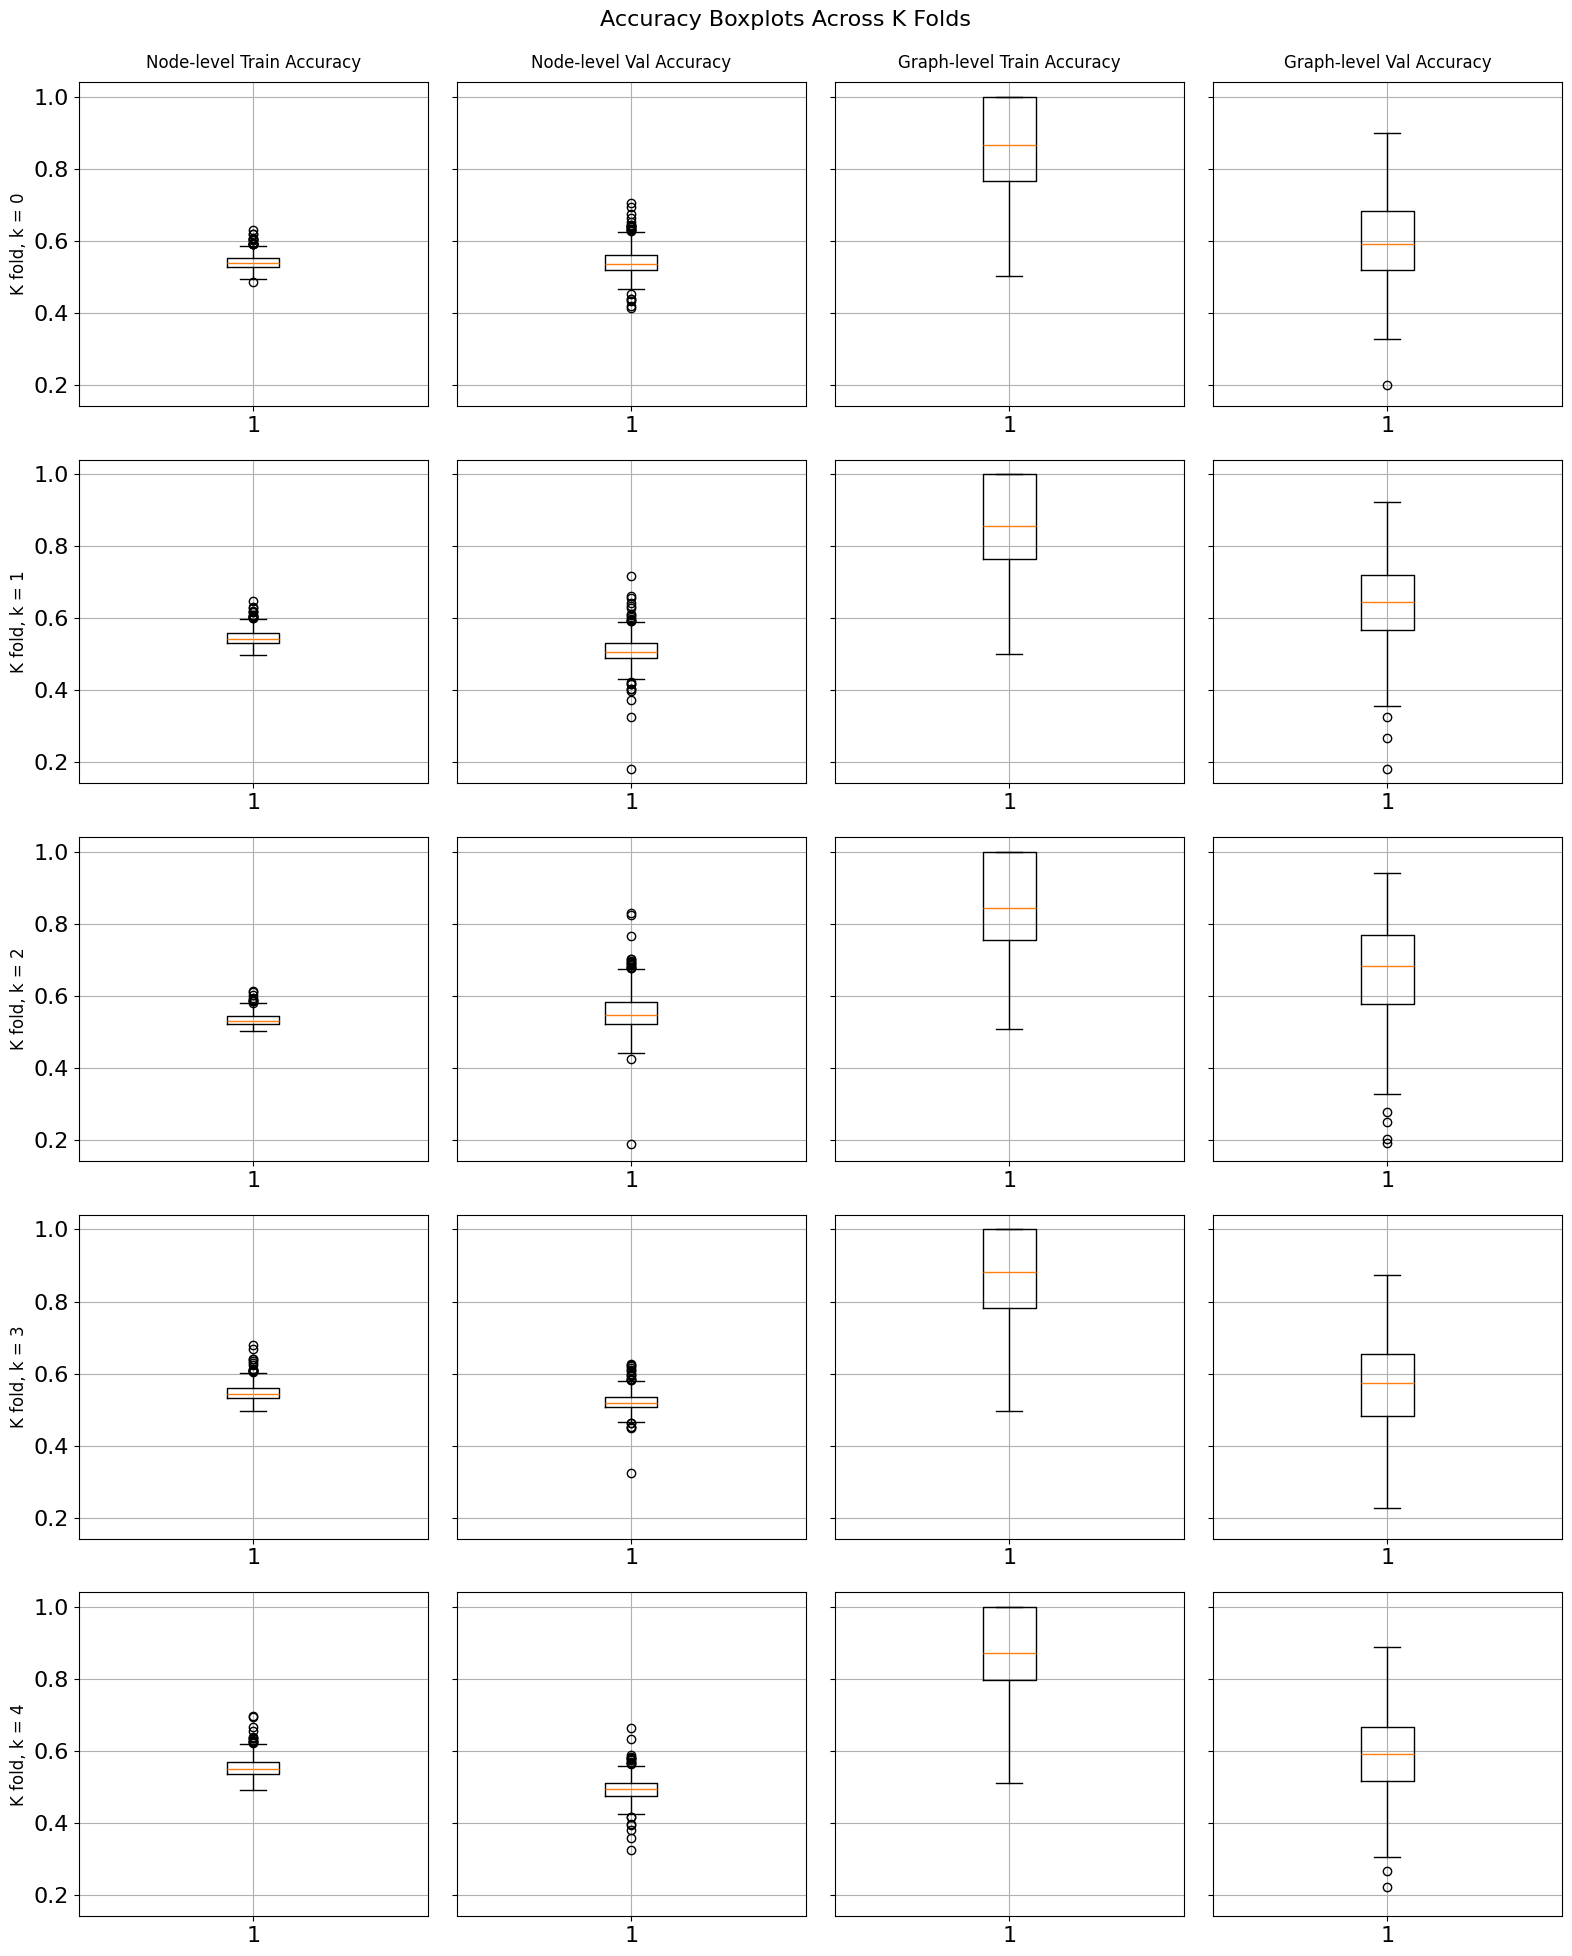

In [30]:
fig, axes = plt.subplots(5, 4, figsize=(16, 20), sharey=True)

# Define labels
row_labels = [f'K fold, k = {i}' for i in range(5)]
col_labels = [
    'Node-level Train Accuracy',
    'Node-level Val Accuracy',
    'Graph-level Train Accuracy',
    'Graph-level Val Accuracy'
]

# Plot boxplots
for i in range(5):
    for j in range(4):
        axes[i, j].boxplot(accuracy_scores[i][j])
        axes[i, j].grid(True)
        
        # Label only the top row columns
        if i == 0:
            axes[i, j].set_title(col_labels[j], fontsize=12, pad=10)
        
        # Label only the first column rows
        if j == 0:
            axes[i, j].set_ylabel(row_labels[i], fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for top labels
fig.suptitle('Accuracy Boxplots Across K Folds', fontsize=16)
plt.show()


In [31]:
final_val_aucs

[0.6090909090909091,
 0.7884615384615384,
 0.7884615384615385,
 0.6272727272727272,
 0.712962962962963]

In [32]:
def k_fold_run(C_val, l1_ratio):
    print("(C, l1): ({}, {})".format(C_val, l1_ratio))
    final_train_aucs = []
    final_val_aucs = []
    
    accuracy_scores = []
    print("Hi!")
    for k in range(5):
        print("K: {}".format(k))
        X_train_patient = []
        X_val_patient = []
        
        # 0 is node level train, 1 is node level val, 2 is graph level train, 3 is graph level val.
        accuracies = [[], [], [], []]
        for graph_num in range(get_num_graphs()):
            if graph_num % 50 == 0:
                print(graph_num)
            cur_X, cur_Y = get_graph_info(graph_num)
            
            X_train, X_test, y_train, y_test, num_nodes, _ = divide_and_scale(cur_X, cur_Y)
            
            X_train, y_train, X_val, y_val =  cross_validation(X_train, y_train, k, num_nodes)
            
            model = LogisticRegression(penalty="elasticnet", C=C_val, solver='saga', l1_ratio=l1_ratio, max_iter=10000)
            model.fit(X_train, y_train)
            
            acc_train = get_auc(model, X_train, y_train, "Train")
            acc_val = get_auc(model, X_val, y_val, "Validation")
        
            accuracies[0].append(acc_train)
            accuracies[1].append(acc_val)
        
            logits_train = model.decision_function(X_train).reshape(NUM_TRAIN - NUM_VAL, -1)
            logits_val = model.decision_function(X_val).reshape(NUM_VAL, -1)
        
            scaler = StandardScaler()
        
            scaler.fit(logits_train)
        
            logits_train = scaler.transform(logits_train)
            logits_val = scaler.transform(logits_val)
            
            y_graph_train = y_train[::logits_train.shape[1]]
            y_graph_val = y_val[::logits_train.shape[1]]
            
            graph_level_model = LogisticRegression(penalty="elasticnet", C=C_val, solver='saga', l1_ratio=l1_ratio, max_iter=10000)
            
            graph_level_model.fit(logits_train, y_graph_train)
            
            acc_train_graph = get_auc(graph_level_model, logits_train, y_graph_train, "Graph-Level Train")
            acc_val_graph = get_auc(graph_level_model, logits_val, y_graph_val, "Graph-Level Validation")
            
            
            accuracies[2].append(acc_train_graph)
            accuracies[3].append(acc_val_graph)
        
            
            X_train_patient.append(graph_level_model.decision_function(logits_train))
            X_val_patient.append(graph_level_model.decision_function(logits_val))
        
        X_train_patient = np.array(X_train_patient).T
        X_val_patient = np.array(X_val_patient).T
        
        scaler.fit(X_train_patient)
        X_train_patient = scaler.transform(X_train_patient)
        X_val_patient = scaler.transform(X_val_patient)
        
        patient_level_model = LogisticRegression(penalty="elasticnet", C=C_val, solver='saga', l1_ratio=l1_ratio, max_iter=10000)
        
        patient_level_model.fit(X_train_patient, y_graph_train)
        
        final_train_auc = get_auc(patient_level_model, X_train_patient, y_graph_train, "Patient Level Train")
        final_val_auc = get_auc(patient_level_model, X_val_patient, y_graph_val, "Patient Level Val")
        
        print("Final Train AUC: {}".format(final_train_auc))
        print("Final Val AUC: {}".format(final_val_auc))
        
        final_train_aucs.append(final_train_auc)
        final_val_aucs.append(final_val_auc)
        accuracy_scores.append(accuracies)
    
    average_train_auc = sum(final_train_aucs) / len(final_train_aucs)
    avg_val_auc = sum(final_val_aucs) / len(final_val_aucs)

    key = (C_val, l1_ratio)

    return average_train_auc, avg_val_auc

In [33]:
C_vals = [0.05 * i for i in range(1, 8)]
l1_ratios = [0.2 * i for i in range(1, 6)]
[0, 0.1, 0.2, 0.3] 
train_aucs = []
val_aucs = []


for C_val in C_vals:
    cur_train_auc = []
    cur_val_auc = []
    
    for l1_ratio in l1_ratios:
        train_auc, val_auc = k_fold_run(C_val, l1_ratio)
        cur_train_auc.append(train_auc)
        cur_val_auc.append(val_auc)

    train_aucs.append(cur_train_auc)
    val_aucs.append(cur_val_auc)

(C, l1): (0.05, 0.2)
Hi!
K: 0
0
50
100
150
200
250
300
Final Train AUC: 0.971341463414634
Final Val AUC: 0.8727272727272728
K: 1
0
50
100
150
200
250
300
Final Train AUC: 0.9465601965601966
Final Val AUC: 0.8173076923076922
K: 2
0
50
100
150
200
250
300
Final Train AUC: 0.9792429792429792
Final Val AUC: 0.9423076923076923
K: 3
0
50
100
150
200
250
300
Final Train AUC: 0.9774114774114775
Final Val AUC: 0.8
K: 4
0
50
100
150
200
250
300
Final Train AUC: 0.9585365853658536
Final Val AUC: 0.6851851851851852
(C, l1): (0.05, 0.4)
Hi!
K: 0
0
50
100
150
200
250
300
Final Train AUC: 0.9146341463414634
Final Val AUC: 0.8636363636363635
K: 1
0
50
100
150
200
250
300
Final Train AUC: 0.8912776412776412
Final Val AUC: 0.6538461538461537
K: 2
0
50
100
150
200
250
300
Final Train AUC: 0.8974358974358975
Final Val AUC: 0.9038461538461539
K: 3
0
50
100
150
200
250
300
Final Train AUC: 0.9505494505494505
Final Val AUC: 0.6636363636363637
K: 4
0
50
100
150
200
250
300
Final Train AUC: 0.9213414634146342


In [103]:
def make_heatmap(title, data, x_ticks, y_ticks, xlabel = "L1-Reg", y_label = "Group Reg"):
    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap="cividis")
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(x_ticks)), labels=[f"{gl:.2f}" for gl in x_ticks],
                  rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(y_ticks)), labels=[f"{l1:.2f}" for l1 in y_ticks])
    
    text_size = min(10, 300 / max(len(x_ticks), len(y_ticks)))

    
    train_auc = np.round(data, decimals=3)
    # Loop over data dimensions and create text annotations.
    for i in range(len(y_ticks)):
        for j in range(len(x_ticks)):
            text = ax.text(j, i, f"{train_auc[i, j]}",
                           ha="center", va="center", color="red", fontsize=text_size)
    
    ax.set_title(title)

    plt.xlabel(xlabel)
    plt.ylabel(y_label)
    plt.show()



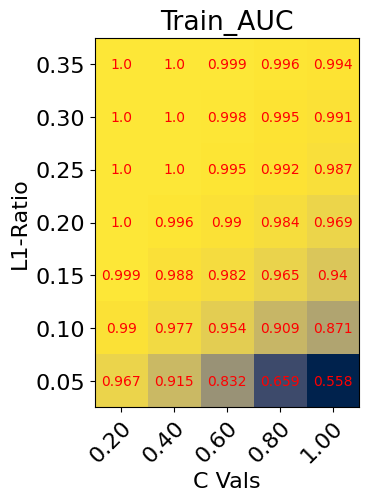

In [104]:
make_heatmap("Train_AUC", train_aucs[::-1], l1_ratios, C_vals[::-1], "C Vals", "L1-Ratio") 

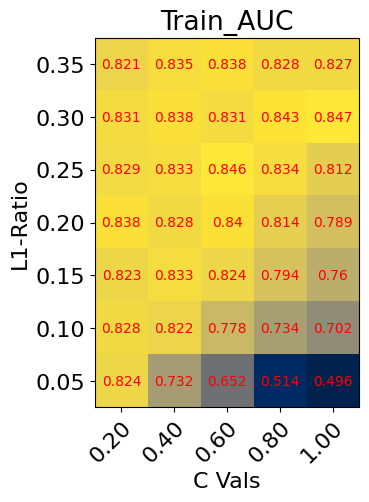

In [105]:
make_heatmap("Train_AUC", val_aucs[::-1], l1_ratios, C_vals[::-1], "C Vals", "L1-Ratio") 

In [109]:
max_index_flat = np.argmax(val_aucs)
val_aucs = np.array(val_aucs)

# Convert the flat index to a coordinate tuple
best_coords = np.unravel_index(max_index_flat, val_aucs.shape)
print(f"Coordinates of max value: {best_coords}") # Output: (1, 0)
print(f"Maximum value: {val_aucs[best_coords]}") # Output: 60

Coordinates of max value: (np.int64(5), np.int64(4))
Maximum value: 0.8473025123025122


In [110]:
best_Cval = C_vals[best_coords[0]]
best_ratio = l1_reg_lasso[best_coords[1]]

print(f"Best C-val and L1-Ratio: {(best_Cval, best_ratio)}")

Best C-val and L1-Ratio: (0.30000000000000004, 0.2)


In [ ]:
C_val = best_Cval
l1_ratio = best_ratio

X_train_patient = []
X_test_patient = []

# 0 is node level train, 1 is node level test, 2 is graph level train, 3 is graph level test.
accuracies = [[], [], [], []]

node_models = []
node_transformers = []
node_logits = []

graph_models = []
graph_transformers = []
graph_logits = []

final_logits = []

for graph_num in range(get_num_graphs()):
    if graph_num % 50 == 0:
        print(graph_num)
    cur_X, cur_Y = get_graph_info(graph_num)
    
    X_train, X_test, y_train, y_test, num_nodes, transformer = divide_and_scale(cur_X, cur_Y)

    node_transformers.append(transformer)
        
    model = LogisticRegression(penalty="elasticnet", C=C_val, solver='saga', l1_ratio=l1_ratio, max_iter=100000)
    model.fit(X_train, y_train)
    
    acc_train = get_auc(model, X_train, y_train, "Train")
    acc_test = get_auc(model, X_test, y_test, "Test")

    accuracies[0].append(acc_train)
    accuracies[1].append(acc_test)

    node_models.append(model)

    logits_train = model.decision_function(X_train).reshape(NUM_TRAIN, -1)
    logits_test = model.decision_function(X_test).reshape((NUM_EXAMPLES - NUM_TRAIN), -1)

    scaler = StandardScaler()

    scaler.fit(logits_train)
    graph_transformers.append(scaler)


    logits_train = scaler.transform(logits_train)
    logits_test = scaler.transform(logits_test)
    node_logits.append(np.vstack((logits_train, logits_test)))
    y_graph_train = y_train[::logits_train.shape[1]]
    y_graph_test = y_test[::logits_train.shape[1]]
    
    graph_level_model = LogisticRegression(penalty="elasticnet", C=C_val, solver='saga', l1_ratio=l1_ratio, max_iter=10000)
    
    graph_level_model.fit(logits_train, y_graph_train)
    
    acc_train_graph = get_auc(graph_level_model, logits_train, y_graph_train, "Graph-Level Train")
    acc_test_graph = get_auc(graph_level_model, logits_test, y_graph_test, "Graph-Level Test")
    
    
    accuracies[2].append(acc_train_graph)
    accuracies[3].append(acc_test_graph)

    graph_models.append(graph_level_model)

    
    X_train_patient.append(graph_level_model.decision_function(logits_train))
    X_test_patient.append(graph_level_model.decision_function(logits_test))

X_train_patient = np.array(X_train_patient).T
X_test_patient = np.array(X_test_patient).T

scaler = StandardScaler()
scaler.fit(X_train_patient)
X_train_patient = scaler.transform(X_train_patient)
X_test_patient = scaler.transform(X_test_patient)

patient_level_model = LogisticRegression(penalty="elasticnet", C=C_val, solver='saga', l1_ratio=l1_ratio, max_iter=10000)

patient_level_model.fit(X_train_patient, y_graph_train)

final_train_auc = get_auc(patient_level_model, X_train_patient, y_graph_train, "Patient Level Train")
final_test_auc = get_auc(patient_level_model, X_test_patient, y_graph_test, "Patient Level Val")

print("Final Train AUC: {}".format(final_train_auc))
print("Final Test AUC: {}".format(final_test_auc))



In [ ]:
train_y = train_df['label']

train_X = train_df.copy()

train_X = train_df.drop('label', axis=1)


train_y

In [ ]:
test_y = test_df['label']

test_X = test_df.copy()

test_X = test_df.drop('label', axis=1)

test_X

In [ ]:
groups = lasso_groups

In [ ]:
gl = LogisticGroupLasso(
    groups=groups,
    group_reg=0.00,
    l1_reg=0,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
)

gl.fit(train_X, train_y)

In [ ]:
# Extract info from estimator
pred_c = gl.predict(train_X)
sparsity_mask = gl.sparsity_mask_
w_hat = gl.coef_

# Compute performance metrics
accuracy = (pred_c == train_y).mean()

# Print results: We are hoping to overfit at this point.
print(f"Number variables: {len(sparsity_mask)}")
print(f"Number of chosen variables: {sparsity_mask.sum()}")
print(f"Accuracy: {accuracy}")

In [ ]:
# Extract info from estimator
pred_c = gl.predict(train_X)
sparsity_mask = gl.sparsity_mask_
w_hat = gl.coef_

# Compute performance metrics
accuracy = (pred_c == train_y).mean()

# Print results: We are hoping to overfit at this point.
print(f"Number variables: {len(sparsity_mask)}")
print(f"Number of chosen variables: {sparsity_mask.sum()}")
print(f"Accuracy: {accuracy}")

In [ ]:
def cross_validation(X_train, y_train, i):
    if(i == 4):
        X_val = X_train[- NUM_VAL:]
        y_val = y_train[- NUM_VAL:]
        
        X_train = X_train[0:-NUM_VAL]
        y_train = y_train[0:-NUM_VAL]
    else:
        X_val = X_train[i * NUM_VAL:(i + 1) * NUM_VAL]
        y_val = y_train[i * NUM_VAL:(i + 1) * NUM_VAL]
        
        X_train = np.concatenate((X_train[:i * NUM_VAL], X_train[(i + 1) * NUM_VAL:]))
        y_train = np.concatenate((y_train[:i * NUM_VAL], y_train[(i + 1) * NUM_VAL:]))


    return X_train, y_train, X_val, y_val

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

def predict(X, true_y, gl):
    # Extract info from estimator
    pred_y = gl.predict(X)
    sparsity_mask = gl.sparsity_mask_
    w_hat = gl.coef_
    
    # Compute performance metrics
    accuracy = (pred_y == true_y).mean()
    
    # Print results: We are hoping to overfit at this point.
    return accuracy

def predict_auc(X, true_y, gl):
    
    pred_y = gl.predict_proba(X)[:,1]
    auc = roc_auc_score(true_y, pred_y)

    return auc

In [ ]:
original_X_train = train_X
orig_y_train = train_y


X_train, y_train, X_val, y_val = cross_validation(original_X_train, orig_y_train, 0)

gl = LogisticGroupLasso(
    groups=groups,
    group_reg=0.00,
    l1_reg=0,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
)

X_train

In [ ]:
print("Train Acc: {}".format(predict_auc(X_train, y_train, gl)))
print("Val Acc: {}".format(predict_auc(X_val, y_val, gl)))

In [ ]:
import warnings
warnings.filterwarnings('ignore')





train_auc = []

val_auc = []




for gr in group_reg_lesso:
    train_auc_row = []
    val_auc_row = []
    for lreg in l1_reg_lasso:
        print("\nGroup Reg: {:.2f} \nL1 Reg: {:.2f}".format(gr, lreg))
        cur_val_auc = []
        cur_train_auc = []
        for k in range(5):
            print("K-fold K: {}".format(k))
            X_train, y_train, X_val, y_val = cross_validation(original_X_train, orig_y_train, k)

            gl = LogisticGroupLasso(
                groups=groups,
                group_reg=gr,
                l1_reg=lreg,
                scale_reg="inverse_group_size",
                subsampling_scheme=1,
                supress_warning=True,
            )

            gl.fit(X_train, y_train)
            cur_train_auc.append(predict_auc(X_train, y_train, gl))
            cur_val_auc.append(predict_auc(X_val, y_val, gl))
        total_train_auc = sum(cur_train_auc) / len(cur_val_auc)
        total_val_auc = sum(cur_val_auc) / len(cur_val_auc)
        
        train_auc_row.append(total_train_auc)
        val_auc_row.append(total_val_auc)
        print("Train AUC: {:.4f}".format(total_train_auc))
        print("Val AUC: {:.4f}".format(total_val_auc))

    train_auc.append(train_auc_row)
    val_auc.append(val_auc_row)


In [ ]:
train_auc = np.array(train_auc)
val_auc = np.array(val_auc)

In [ ]:
train_auc.tolist()

In [ ]:
val_auc

In [ ]:
l1_reg_lasso

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


def make_heatmap(title, data, x_ticks, y_ticks):
    fig, ax = plt.subplots()
    im = ax.imshow(data)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(x_ticks)), labels=[f"{gl:.3f}" for gl in x_ticks],
                  rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(y_ticks)), labels=[f"{l1:.3f}" for l1 in y_ticks])
    
    
    
    train_auc = np.round(data, decimals=3)
    # Loop over data dimensions and create text annotations.
    for i in range(len(y_ticks)):
        for j in range(len(x_ticks)):
            text = ax.text(j, i, train_auc[i, j],
                           ha="center", va="center", color="w")
    
    ax.set_title(title)

    plt.xlabel("L1-Reg")
    plt.ylabel("Group Reg")
    plt.show()

make_heatmap("Train AUC", train_auc[::-1], l1_reg_lasso, group_reg_lesso[::-1])

In [ ]:
make_heatmap("Val AUC", val_auc[::-1], l1_reg_lasso, group_reg_lesso[::-1])

In [ ]:
max_index_flat = np.argmax(val_auc)


# Convert the flat index to a coordinate tuple
best_coords = np.unravel_index(max_index_flat, val_auc.shape)
print(f"Coordinates of max value: {best_coords}") # Output: (1, 0)
print(f"Maximum value: {val_auc[best_coords]}") # Output: 60

In [ ]:
best_gr = group_reg_lesso[best_coords[0]]
best_l1 = l1_reg_lasso[best_coords[1]]

print(f"Best Group Reg and L1-Reg: {(best_gr, best_l1)}")

In [ ]:
gl = LogisticGroupLasso(
    groups=groups,
    group_reg=best_gr,
    l1_reg=best_l1,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
)

gl.fit(X_train, y_train)

In [ ]:
# make this show the names

chosen = [i.item() for i in gl.chosen_groups_]
chosen.sort()

[graph_list[c].name for c in chosen]

In [ ]:
len(gl.chosen_groups_)